In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
#dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}
dict_genres = {'Electronic':0, 'Experimental':1, 'Instrumental':4,'International':5, 'Pop' :6}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 4: 'Instrumental', 5: 'International', 6: 'Pop'}


In [4]:
npzfile = np.load('data/shuffled_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [5]:
y_train_mask = np.in1d(y_train, list(dict_genres.values()))

In [6]:
y_train = y_train[y_train_mask]

In [7]:
y_train = utils.to_categorical(y_train, num_classes=8).astype(int)

In [8]:
X_train = X_train[y_train_mask]

In [9]:
X_train.shape, y_train.shape

((3998, 640, 128), (3998, 8))

In [10]:
npzfile = np.load('data/shuffled_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [11]:
y_valid_mask = np.in1d(y_valid, list(dict_genres.values()))

In [12]:
y_valid = y_valid[y_valid_mask]

In [13]:
y_valid = utils.to_categorical(y_valid, num_classes=8).astype(int)

In [14]:
X_valid = X_valid[y_valid_mask]

In [15]:
X_valid.shape, y_valid.shape

((500, 640, 128), (500, 8))

## Check by plotting a Spectogram

Pop


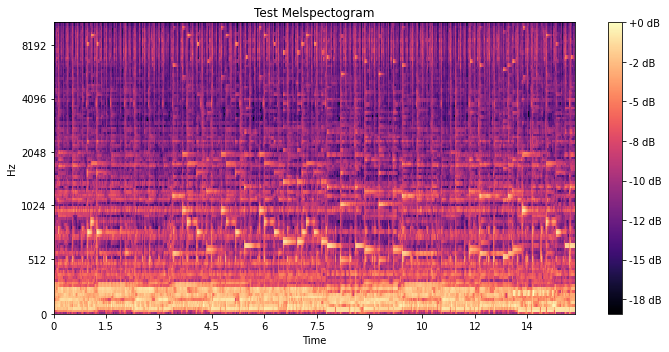

In [16]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [17]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [18]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

BATCH_SIZE = 64
EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [19]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 640
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/tree_2/model_root_f1_1_1/"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/tree_2/model_root_f1_1_1/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [20]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [21]:
def create_split(elem, c):
    splits = []
    for i in range(c):
        equal = False
        np.random.shuffle(elem)
        new_split = list(chunks(elem, int(len(elem)/2)))
        for split in splits:
            if set(new_split[0]) == set(split[0]) and set(new_split[0]) == set(split[1]):
                equal = True
                break
            
        if equal:
            i-=1
            continue
        
        splits.append(new_split)
        
    return splits

In [22]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Folder num 1
Genre split [['Electronic'], ['Experimental', 'Instrumental', 'International', 'Pop']]
Building model...
Training...
Epoch 1/30
62/62 [==============================] - 26s 195ms/step - loss: 0.9008 - accuracy: 0.7842 - val_loss: 0.5054 - val_accuracy: 0.7904

Epoch 00001: val_accuracy improved from -inf to 0.79041, saving model to ./models/tree_2/model_root_f1_1_1/folder1\model.h5
Epoch 2/30
62/62 [==============================] - 9s 146ms/step - loss: 0.4885 - accuracy: 0.8025 - val_loss: 0.5099 - val_accuracy: 0.7904

Epoch 00002: val_accuracy did not improve from 0.79041
Epoch 3/30
62/62 [==============================] - 9s 146ms/step - loss: 0.4684 - accuracy: 0.8020 - val_loss: 0.4459 - val_accuracy: 0.8171

Epoch 00003: val_accuracy improved from 0.79041 to 0.81705, saving model to ./models/tree_2/model_root_f1_1_1/folder1\model.h5
Epoch 4/30
62/62 [==============================] - 9s 146ms/step - loss: 0.4281 - accuracy: 0.8117 - val_loss: 0.4031 - val_accuracy:

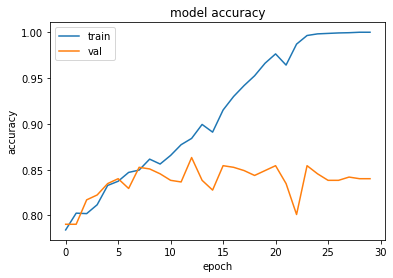

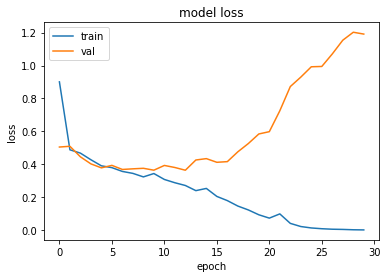

Folder num 2
Genre split [['Experimental'], ['Electronic', 'Instrumental', 'International', 'Pop']]
Building model...
Training...
Epoch 1/30
62/62 [==============================] - 11s 153ms/step - loss: 0.7298 - accuracy: 0.7761 - val_loss: 0.4849 - val_accuracy: 0.8224

Epoch 00001: val_accuracy improved from -inf to 0.82238, saving model to ./models/tree_2/model_root_f1_1_1/folder2\model.h5
Epoch 2/30
62/62 [==============================] - 9s 147ms/step - loss: 0.4842 - accuracy: 0.7970 - val_loss: 0.4294 - val_accuracy: 0.8224

Epoch 00002: val_accuracy did not improve from 0.82238
Epoch 3/30
62/62 [==============================] - 9s 146ms/step - loss: 0.4722 - accuracy: 0.7982 - val_loss: 0.4193 - val_accuracy: 0.8224

Epoch 00003: val_accuracy did not improve from 0.82238
Epoch 4/30
62/62 [==============================] - 9s 148ms/step - loss: 0.4545 - accuracy: 0.8074 - val_loss: 0.4067 - val_accuracy: 0.8330

Epoch 00004: val_accuracy improved from 0.82238 to 0.83304, sav

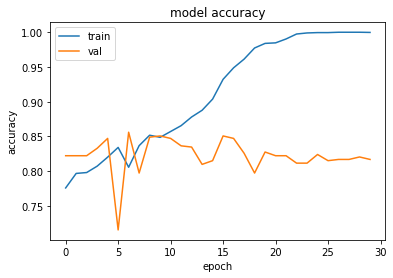

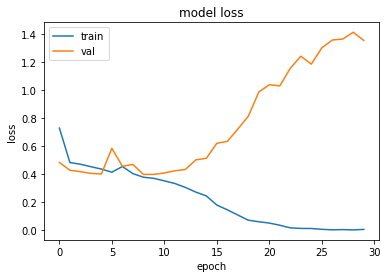

Folder num 3
Genre split [['Instrumental'], ['Electronic', 'Experimental', 'International', 'Pop']]
Building model...
Training...
Epoch 1/30
62/62 [==============================] - 13s 195ms/step - loss: 0.9109 - accuracy: 0.7729 - val_loss: 0.4746 - val_accuracy: 0.8292

Epoch 00001: val_accuracy improved from -inf to 0.82918, saving model to ./models/tree_2/model_root_f1_1_1/folder3\model.h5
Epoch 2/30
62/62 [==============================] - 9s 147ms/step - loss: 0.4690 - accuracy: 0.7993 - val_loss: 0.4123 - val_accuracy: 0.8292

Epoch 00002: val_accuracy did not improve from 0.82918
Epoch 3/30
62/62 [==============================] - 9s 147ms/step - loss: 0.4622 - accuracy: 0.7922 - val_loss: 0.4078 - val_accuracy: 0.8292

Epoch 00003: val_accuracy did not improve from 0.82918
Epoch 4/30
62/62 [==============================] - 9s 147ms/step - loss: 0.4309 - accuracy: 0.8008 - val_loss: 0.4056 - val_accuracy: 0.8683

Epoch 00004: val_accuracy improved from 0.82918 to 0.86833, sav

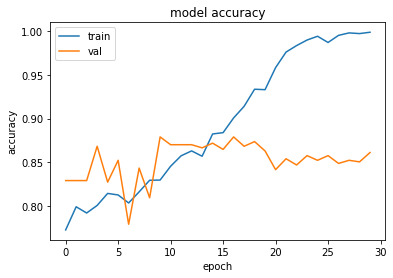

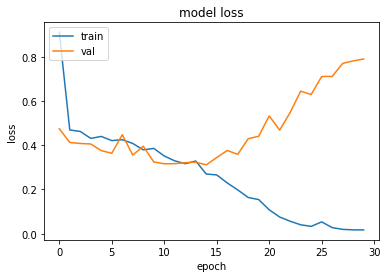

Folder num 4
Genre split [['International'], ['Electronic', 'Experimental', 'Instrumental', 'Pop']]
Building model...
Training...
Epoch 1/30
62/62 [==============================] - 10s 152ms/step - loss: 0.9021 - accuracy: 0.7810 - val_loss: 0.5139 - val_accuracy: 0.7936

Epoch 00001: val_accuracy improved from -inf to 0.79359, saving model to ./models/tree_2/model_root_f1_1_1/folder4\model.h5
Epoch 2/30
62/62 [==============================] - 9s 146ms/step - loss: 0.5089 - accuracy: 0.8008 - val_loss: 0.5012 - val_accuracy: 0.7936

Epoch 00002: val_accuracy did not improve from 0.79359
Epoch 3/30
62/62 [==============================] - 9s 146ms/step - loss: 0.5055 - accuracy: 0.7945 - val_loss: 0.5588 - val_accuracy: 0.7936

Epoch 00003: val_accuracy did not improve from 0.79359
Epoch 4/30
62/62 [==============================] - 12s 194ms/step - loss: 0.4986 - accuracy: 0.8003 - val_loss: 0.5189 - val_accuracy: 0.7900

Epoch 00004: val_accuracy did not improve from 0.79359
Epoch 5

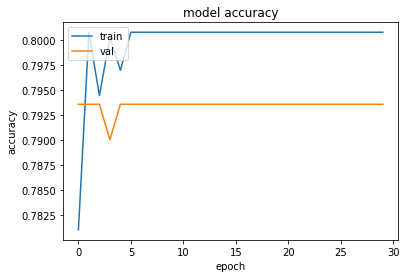

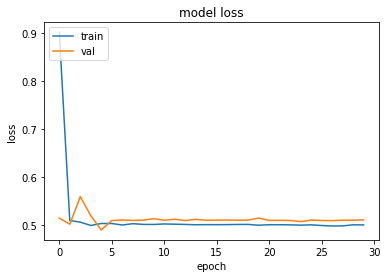

Folder num 5
Genre split [['Pop'], ['Electronic', 'Experimental', 'Instrumental', 'International']]
Building model...
Training...
Epoch 1/30
62/62 [==============================] - 10s 152ms/step - loss: 1.0250 - accuracy: 0.7774 - val_loss: 0.4453 - val_accuracy: 0.8345

Epoch 00001: val_accuracy improved from -inf to 0.83452, saving model to ./models/tree_2/model_root_f1_1_1/folder5\model.h5
Epoch 2/30
62/62 [==============================] - 9s 147ms/step - loss: 0.5055 - accuracy: 0.7950 - val_loss: 0.4417 - val_accuracy: 0.8345

Epoch 00002: val_accuracy did not improve from 0.83452
Epoch 3/30
62/62 [==============================] - 9s 147ms/step - loss: 0.4990 - accuracy: 0.7950 - val_loss: 0.4489 - val_accuracy: 0.8345

Epoch 00003: val_accuracy did not improve from 0.83452
Epoch 4/30
62/62 [==============================] - 9s 147ms/step - loss: 0.5001 - accuracy: 0.7950 - val_loss: 0.4975 - val_accuracy: 0.8345

Epoch 00004: val_accuracy did not improve from 0.83452
Epoch 5/

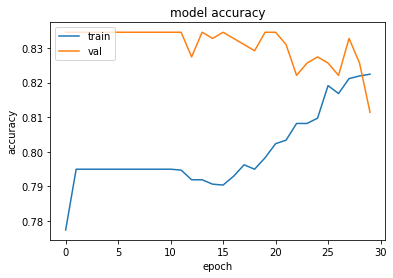

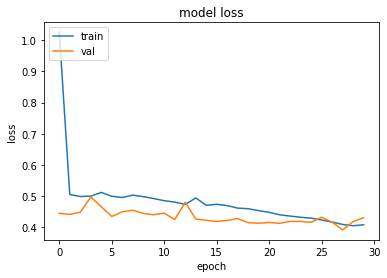

In [23]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

num_splits = 5

kfold = KFold(n_splits=8, shuffle=True)
genre_splits = create_split(list(dict_genres.values()), num_splits)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    dict_genres_list = list(dict_genres.values())
    split = [[dict_genres_list.pop(fold_no - 1)], dict_genres_list]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)

    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break